# Imports

In [1]:
import math
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader, Subset
from torch import Tensor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Optional

torch.set_default_dtype(torch.float32)

# RBF Kernel

In [2]:
# RBF kernel with learnable hyperparameters and jitter
def rbf_kernel(
        x1: torch.Tensor,
        x2: torch.Tensor,
        lengthscale: float,
        variance: float,
        jitter: float = 1e-6
    ) -> torch.Tensor:
    """
    Radial Basis Function (RBF) kernel with learnable log-hyperparameters and jitter.
    k(x, x') = variance * exp(-0.5 * ||x - x'||^2 / lengthscale^2)
    """
    diff = x1.unsqueeze(1) - x2.unsqueeze(0)  # [N, M, D]
    K = variance * torch.exp(-0.5 * (diff**2).sum(-1) / lengthscale**2)  # [N, M]

    # Add jitter on the diagonal when x1 == x2
    if x1.shape == x2.shape and torch.allclose(x1, x2):
        K = K + jitter * torch.eye(x1.size(0), device=K.device, dtype=K.dtype)

    return K

# Sparse GP Class

In [3]:
# Sparse GP Transition Model
class SparseGP(nn.Module):
    """
    Sparse, mean-field variational GP for the transition:
      q(u_d) = N(m_d, S_d),  p(u_d) = N(mean(Z), Kzz)
    Posterior predictive:
      mu_d(x) = mean_d(x) + k(x,Z) Kzz^{-1} (m_d - mean_d(Z))
      var_d(x) = k(x,x) - k(x,Z) Kzz^{-1} [Kzz - S_d] Kzz^{-1} k(Z,x)
    """
    def __init__(self, Z: torch.Tensor, state_dim: int):
        super().__init__()
        self.Z = Z
        self.M, self.input_dim = Z.shape
        self.state_dim = state_dim

        # Learnable GP hyperparameters: log-lengthscale and log-variance
        self.log_ls = nn.Parameter(torch.zeros(()))
        self.log_var = nn.Parameter(torch.zeros(()))

        # Variational parameters; set in init_variational
        self.m = None  # [D, M]
        self.S = None  # [D, M, M]

    def init_variational(self, D: int):
        """Initialize q(u_d)=N(m_d, S_d) with S_d = Kzz."""
        self.m = nn.Parameter(torch.zeros(D, self.M))
        with torch.no_grad():
            Kzz = rbf_kernel(
                self.Z,
                self.Z,
                self.log_ls.exp(),
                self.log_var.exp()
            )
        S0 = Kzz.unsqueeze(0).repeat(D, 1, 1)
        self.S = nn.Parameter(S0)

    def prior_Kzz(self) -> torch.Tensor:
        """Compute the prior covariance Kzz = k(Z, Z)."""
        return rbf_kernel(
            self.Z,
            self.Z,
            self.log_ls.exp(),
            self.log_var.exp()
        )

    def kl_U(self) -> torch.Tensor:
        """
        KL[q(U) || p(U)] summed over output dimensions.
        p(u_d)=N(mean(Z), Kzz), mean_d(Z)=Z[:, d].
        """
        Kzz = self.prior_Kzz()   # [M, M]
        Ki = torch.inverse(Kzz)  # [M, M]
        logdet_K = torch.logdet(Kzz)
        D = self.m.size(0)

        # Mean(Z): [D, M], each row d = Z[:, d]
        meanZ = self.Z[:, :self.state_dim].t()  # [D, M]

        kl = 0.0
        for d in range(D):
            md, Sd = self.m[d], self.S[d]  # md:[M], Sd:[M,M]
            trace_term = torch.trace(Ki @ Sd)
            quad_term = (md - meanZ[d]) @ (Ki @ (md - meanZ[d]))
            logdet_S = torch.logdet(Sd)
            kl += 0.5 * (trace_term + quad_term - self.M + logdet_K - logdet_S)
        return kl

    def predict_f(
            self,
            x: torch.Tensor
        ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Posterior predictive mean and variance at inputs x.
        Args:
          x: [B, input_dim]
        Returns:
          mu:  [B, D]
          var: [B, D]
        """
        B = x.size(0)
        D = self.m.size(0)
        sigma_f2 = self.log_var.exp()
        ls = self.log_ls.exp()

        Kzz = self.prior_Kzz()
        Ki = torch.inverse(Kzz)
        Kxz = rbf_kernel(x, self.Z, ls, sigma_f2)  # [B, M]

        meanX = x[:, :self.state_dim]              # [B, D]
        meanZ = self.Z[:, :self.state_dim].t()     # [D, M]

        mu = torch.zeros(B, D, dtype=x.dtype, device=x.device)
        var = torch.zeros(B, D, dtype=x.dtype, device=x.device)

        for d in range(D):
            md, Sd = self.m[d], self.S[d]
            mu[:, d] = meanX[:, d] + Kxz @ (Ki @ (md - meanZ[d]))
            kxx = sigma_f2 * torch.ones(B, dtype=x.dtype, device=x.device)
            tmp = Ki @ (Kzz - Sd) @ Ki
            var[:, d] = kxx - torch.sum((Kxz @ tmp) * Kxz, dim=1)

        # Clamp for stability
        var = var.clamp(min=1e-6)
        return mu, var

# Recognition Network

In [4]:
# Recognition Network for q(X)
class RecognitionNet(nn.Module):
    """
    Bidirectional GRU -> parameters of q(x0), q(xt | x_{t-1}):
      q(x0)=N(m0, L0 L0^T),  q(xt|x_{t-1})=N(A_t x_{t-1}, L_t L_t^T)
    """
    def __init__(
            self,
            obs_dim: int,
            act_dim: int,
            hid_dim: int,
            state_dim: int
        ):
        super().__init__()
        self.state_dim = state_dim
        self.rnn = nn.GRU(
            obs_dim + act_dim,
            hid_dim,
            batch_first=True,
            bidirectional=True
        )
        D = state_dim
        self.lin_A = nn.Linear(2 * hid_dim, D * D)
        self.lin_L = nn.Linear(2 * hid_dim, D * (D + 1) // 2)
        self.lin_m0 = nn.Linear(hid_dim, D)
        self.lin_L0 = nn.Linear(hid_dim, D * (D + 1) // 2)

    def forward(self, y: torch.Tensor, a: torch.Tensor):
        """
        Encode observations+actions -> {m0, L0}, {A_t, L_t}.

        Args:
          y: [B, T, obs_dim]
          a: [B, T, act_dim]
        Returns:
          m0:   [B, D]
          L0_f: [B, D*(D+1)//2]
          A:    [B, T, D, D]
          L_f:  [B, T, D*(D+1)//2]
        """
        B, T, _ = y.shape
        inp = torch.cat([y, a], dim=-1)       # [B, T, obs+act]
        H, h_n = self.rnn(inp)                # H:[B,T,2H], h_n:[2,B,H]

        D = self.state_dim
        A_flat = self.lin_A(H).view(B, T, D, D)
        L_flat = self.lin_L(H)                # [B, T, D*(D+1)//2]

        # Backward final hidden -> x0 params
        h_back = h_n[1]                       # [B, H]
        m0 = self.lin_m0(h_back)              # [B, D]
        L0_f = self.lin_L0(h_back)            # [B, D*(D+1)//2]

        return m0, L0_f, A_flat, L_flat

In [5]:
def flat_to_lower(Lf: torch.Tensor, D: int) -> torch.Tensor:
    """
    Out-of-place conversion of flat triangular entries to a lower-triangular matrix L.
    Lf: [N, M] where M = D*(D+1)//2
    Returns L: [N, D, D], with diag entries softplus’d.
    """
    # Lf is shape [N, M]
    N, M = Lf.shape
    device, dtype = Lf.device, Lf.dtype

    # Tril indices once
    idx0, idx1 = torch.tril_indices(D, D, device=device)
    # Compute linear indices into a (D*D) vector
    lin_idx = idx0 * D + idx1  # [M]
    lin_idx = lin_idx.unsqueeze(0).expand(N, -1)  # [N, M]

    # Start with a flat [N, D*D] zero tensor
    out_flat = torch.zeros(N, D*D, device=device, dtype=dtype)
    # Scatter Lf into the lower-triangular positions
    out_flat = out_flat.scatter(1, lin_idx, Lf)

    # Apply softplus to the diagonal entries
    # Diagonal linear indices are 0, D+1, 2(D+1), ..., (D-1)(D+1)
    diag_idx = torch.arange(0, D*D, D+1, device=device)
    diag_idx = diag_idx.unsqueeze(0).expand(N, -1)  # [N, D]
    # Gather current diag
    diag_vals = out_flat.gather(1, diag_idx)        # [N, D]
    # Softplus
    diag_sp = torch.nn.functional.softplus(diag_vals)
    # Scatter them back
    out_flat = out_flat.scatter(1, diag_idx, diag_sp)

    # Reshape into [N, D, D]
    return out_flat.view(N, D, D)

# GPSSM Class

In [6]:
# GPSSM Model and Exact ELBO
class GPSSM(nn.Module):
    """
    Full GPSSM model:
      - SparseGP transition
      - RecognitionNet posterior
      - Exact ELBO: KL[u], KL[x0], H[q(X)], E[log p(y|x)], E[log p(x|f)]
    """
    def __init__(
            self,
            obs_dim: int,
            act_dim: int,
            state_dim: int,
            hid_dim: int,
            Z: torch.Tensor,
            num_mc_samples: int = 1
        ):
        super().__init__()
        self.state_dim = state_dim
        self.num_mc = num_mc_samples

        # (1) Sparse GP transition
        self.gp = SparseGP(Z, state_dim)
        self.gp.init_variational(state_dim)

        # (2) Recognition network q(X)
        self.rec = RecognitionNet(obs_dim, act_dim, hid_dim, state_dim)

        # (3) Observation model p(y_t|x_t)=N(Wg x_t + bg, sigma_g2 I)
        self.Wg = nn.Linear(state_dim, obs_dim, bias=True)
        self.log_sigma_g2 = nn.Parameter(torch.zeros(()))

    def elbo(self, y: torch.Tensor, a: torch.Tensor) -> torch.Tensor:
        """
        Compute one-sample ELBO estimate:
            ELBO = Eq_x0 + H[q(X)] - KL[q(U)||p(U)]
                 + E_q[log p(y|x)] + E_q[log p(x|f)]
        Returns:
            ELBO averaged over batch
        """
        B, T, _ = y.shape
        D = self.state_dim

        # Unpack q(X)
        m0, L0_f, A, L_f = self.rec(y, a)
        L0 = flat_to_lower(L0_f, D)                    # [B, D, D]
        Lt = flat_to_lower(L_f.reshape(B * T, -1), D)  # [B*T, D, D]
        Lt = Lt.reshape(B, T, D, D).contiguous()       # Break any strides

        # KL over GP inducing points (U)
        kl_u = self.gp.kl_U()

        # KL over initial state q(x0)||p(x0)=N(0,I)
        Sigma0 = L0 @ L0.transpose(-1, -2)               # [B, D, D]
        tr0 = Sigma0.diagonal(dim1=-2, dim2=-1).sum(-1)  # [B]
        ld0 = torch.logdet(Sigma0 + 1e-6*torch.eye(D, device=Sigma0.device))  # [B]
        m0norm2 = (m0**2).sum(-1)                        # [B]
        kl_x0 = 0.5 * torch.sum(tr0 + m0norm2 - D - ld0)

        # Entropy H[q(X)]
        H_const = 0.5 * (T + 1) * D * math.log(2*math.pi*math.e)
        # Vectorised log-dets of LtLt^T
        Lt_flat = Lt.reshape(B*T, D, D)
        SigmaL = Lt_flat @ Lt_flat.transpose(-1, -2)   # [B*T, D, D]
        ld_Lt = torch.logdet(SigmaL)                   # [B*T]
        ld_Lt_bt = ld_Lt.reshape(B, T)                 # [B, T]
        # Assemble entropy
        H_term = H_const + 0.5 * torch.sum(ld0.unsqueeze(-1) + ld_Lt_bt)

        # Observation term E_q[log p(y|x)]
        sigma_g2 = torch.exp(self.log_sigma_g2)
        m_t, S_t = m0, Sigma0
        Ey_terms = []
        for t in range(T):
            mu_y = self.Wg(m_t)
            cov  = (
                self.Wg.weight @ S_t @ self.Wg.weight.t()
                + sigma_g2 * torch.eye(
                    mu_y.size(-1),
                    dtype=mu_y.dtype,
                    device=mu_y.device
                )
            )
            diff = (y[:,t] - mu_y).unsqueeze(-1)  # [B,1,1]
            Ey = -0.5 * torch.sum(
                diff.transpose(-1,-2) @ torch.inverse(cov) @ diff
                + torch.logdet(2*torch.pi*cov),
                dim=(1, 2)
            )  # [B]
            Ey_terms.append(Ey)
            # Propagate forward
            m_t = (A[:,t] @ m_t.unsqueeze(-1)).squeeze(-1)
            S_t = (A[:,t] @ S_t @ A[:,t].transpose(-1,-2)
                + Lt[:,t] @ Lt[:,t].transpose(-1,-2))
        E_logy = torch.sum(torch.stack(Ey_terms))  # scalar

        # Transition term (MC)
        trans_samples = []
        for _ in range(self.num_mc):
            eps0 = torch.randn(B, D, 1, dtype=y.dtype, device=y.device)
            x_prev = m0.unsqueeze(-1) + L0 @ eps0
            lp_list = []
            for t in range(T):
                inp = torch.cat([x_prev.squeeze(-1), a[:,t]], dim=-1)
                mu_f, var_f = self.gp.predict_f(inp)  # [B,D]
                mu_f, var_f = mu_f.unsqueeze(-1), var_f.unsqueeze(-1)
                eps = torch.randn_like(var_f)
                x_lin = A[:,t] @ x_prev
                x_t = x_lin + Lt[:,t] @ eps
                diff2 = (x_t - mu_f)**2
                lp = 0.5 * torch.sum(
                    -diff2/var_f
                    - torch.log(2*torch.pi*var_f),
                    dim=(1, 2)
                )  # [B]
                lp_list.append(lp)
                x_prev = x_t
            trans_samples.append(torch.sum(torch.stack(lp_list)))
        trans = torch.mean(torch.stack(trans_samples))  # scalar

        # Combine all terms
        elbo = -kl_u - kl_x0 + H_term + E_logy + trans
        return elbo / B

    def forward(self, y: torch.Tensor, a: torch.Tensor) -> torch.Tensor:
        """Negative ELBO (for minimisation)."""
        return -self.elbo(y, a)

    def forecast(
            self,
            y_obs: torch.Tensor,
            a_obs: torch.Tensor = None,
            horizon: int = 30,
            actions_future: torch.Tensor = None,
            use_map: bool = True,
            num_samples: int = 1
        ):
        """
        Forecast future y for `horizon` steps given observed window (y_obs, a_obs).
        If num_samples>1 and use_map=False, draws multiple sample trajectories
        and averages their means and variances.

        Returns:
            y_means: [horizon, obs_dim]
            y_vars: [horizon, obs_dim]
        """
        B, T, _ = y_obs.shape

        # Default zeros if no actions
        if a_obs is None:
            a_obs = torch.zeros(
                B, T,
                self.gp.input_dim - self.state_dim,
                dtype=y_obs.dtype,
                device=y_obs.device
            )
        if actions_future is None:
            actions_future = torch.zeros(
                B, horizon,
                self.gp.input_dim - self.state_dim,
                dtype=y_obs.dtype,
                device=y_obs.device
            )

        # Infer q(x_T)
        m0, L0_f, A, L_f = self.rec(y_obs, a_obs)
        L0 = flat_to_lower(L0_f, self.state_dim)
        Lt = flat_to_lower(
            L_f.view(B * T, -1),
            self.state_dim
        ).view(
            B, T,
            self.state_dim,
            self.state_dim
        )

        # Propagate to get posterior at t = T
        m_t = m0
        Sigma_t = L0 @ L0.transpose(-1, -2)
        for t in range(T):
            m_t = (A[:, t] @ m_t.unsqueeze(-1)).squeeze(-1)
            Sigma_t = (
                A[:, t] @ Sigma_t @ A[:, t].transpose(-1, -2)
                + Lt[:, t] @ Lt[:, t].transpose(-1, -2)
            )

        # Draw num_samples rollouts
        means_list = []
        vars_list = []
        for _ in range(num_samples):
            x_mean, x_cov = m_t, Sigma_t
            y_means = []
            y_vars = []
            for h in range(horizon):
                u = actions_future[:, h, :]
                inp = torch.cat([x_mean, u], dim=-1)
                mu_f, var_f = self.gp.predict_f(inp)
                if use_map:
                    x_mean, x_cov = mu_f, torch.diag_embed(var_f)
                else:
                    eps = torch.randn_like(mu_f)
                    x_mean = mu_f + torch.sqrt(var_f) * eps
                    x_cov = torch.diag_embed(var_f)

                y_mean = self.Wg(x_mean)
                y_cov = (
                    self.Wg.weight @ x_cov @ self.Wg.weight.t()
                    + torch.exp(self.log_sigma_g2) *
                    torch.eye(
                        y_mean.size(-1),
                        device=y_mean.device
                    )
                )
                y_means.append(y_mean.squeeze(0))
                y_vars.append(
                    torch.diagonal(
                        y_cov,
                        dim1=-2,
                        dim2=-1
                    ).squeeze(0)
                )
            means_list.append(torch.stack(y_means))  # [horizon, obs_dim]
            vars_list.append(torch.stack(y_vars))

        # Aggregate across samples
        means_all = torch.stack(means_list)  # [num_samples, horizon, obs_dim]
        vars_all = torch.stack(vars_list)
        y_means = means_all.mean(0)
        y_vars = vars_all.mean(0)

        return y_means, y_vars

# Training Utility

In [7]:
# Training utility
def train(
        model: GPSSM,
        train_loader: DataLoader,
        val_loader: Optional[DataLoader] = None,
        lr: float = 1e-3,
        epochs: int = 100
    ):
    """
    Train GPSSM by minimizing NELBO, snapshotting the parameters
    from the epoch with lowest validation NELBO (if val_loader provided),
    otherwise lowest training NELBO.
    """
    opt = optim.Adam(model.parameters(), lr=lr)
    device = next(model.parameters()).device
    best_loss = float('inf')
    best_params = None
    best_epoch = -1

    for ep in range(1, epochs+1):
        # Training step
        model.train()
        train_sum = 0.0
        for yb, ab in train_loader:
            yb = yb.to(device)
            ab = ab.to(device)

            loss = model(yb, ab)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
            train_sum += loss.item() * yb.size(0)
        train_nelbo = train_sum / len(train_loader.dataset)

        # Evaluation step
        eval_loader = val_loader if val_loader is not None else train_loader
        model.eval()
        eval_sum = 0.0
        with torch.no_grad():
            for yb, ab in eval_loader:
                yb = yb.to(device)
                ab = ab.to(device)
                eval_sum += model(yb, ab).item() * yb.size(0)
        eval_nelbo = eval_sum / len(eval_loader.dataset)

        msg = f"Epoch {ep:03d} | train NELBO = {train_nelbo:.4f}"
        if val_loader is not None:
            msg += f" | val NELBO = {eval_nelbo:.4f}"
        print(msg)

        # Snapshot best
        current = eval_nelbo if val_loader is not None else train_nelbo
        if current < best_loss:
            best_loss = current
            best_epoch = ep
            best_params = copy.deepcopy(model.state_dict())

    # Restore best
    model.load_state_dict(best_params)
    print(f"Restored parameters from epoch {best_epoch} (NELBO={best_loss:.4f})")
    return model

# Time Series Demo

In [8]:
# Generate a noisy sine wave
T_total = 300
t = np.arange(T_total)
series = np.sin(0.05 * t) + 0.1 * np.random.randn(T_total)

# Parameters
window = 50
horizon = 30

In [9]:
# Split into train / val windows

# train: first 200 points (0–200)
train_series = series[:4*window]

# val: next 50 points (200–250)
val_series = series[4*window : 5*window]

# test true: the 30 points after val (250–280)
test_true = series[5*window : 5*window + horizon]

In [10]:
# Convert to tensors
train_y = torch.from_numpy(train_series) \
               .unsqueeze(0).unsqueeze(-1) \
               .float()  # [1, 200, 1]
train_a = torch.zeros(1, train_y.shape[1], 0).float()

val_y = torch.from_numpy(val_series) \
               .unsqueeze(0).unsqueeze(-1) \
               .float()  # [1,  50, 1]
val_a = torch.zeros(1, val_y.shape[1], 0).float()

In [11]:
# DataLoaders
train_loader = DataLoader(
    TensorDataset(train_y, train_a),
    batch_size=1,
    shuffle=False
)

val_loader = DataLoader(
    TensorDataset(val_y, val_a),
    batch_size=1,
    shuffle=False
)

In [12]:
# Instantiate GPSSM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

obs_dim, act_dim, state_dim = 1, 0, 4
hid_dim = 20
M = 20
Z = torch.randn(M, state_dim + act_dim).to(device)

model = GPSSM(
    obs_dim=obs_dim,
    act_dim=act_dim,
    state_dim=state_dim,
    hid_dim=hid_dim,
    Z=Z,
    num_mc_samples=3
).to(device)

In [13]:
# Train with validation
model = train(
    model,
    train_loader,
    val_loader,
    lr=1e-3,
    epochs=300,
)

Epoch 001 | train NELBO = 708.9907 | val NELBO = 180.2938
Epoch 002 | train NELBO = 686.4853 | val NELBO = 181.6796
Epoch 003 | train NELBO = 694.2363 | val NELBO = 182.3280
Epoch 004 | train NELBO = 672.7001 | val NELBO = 186.0271
Epoch 005 | train NELBO = 666.3762 | val NELBO = 182.1589
Epoch 006 | train NELBO = 661.0277 | val NELBO = 175.0560
Epoch 007 | train NELBO = 661.5786 | val NELBO = 186.3603
Epoch 008 | train NELBO = 644.4055 | val NELBO = 179.9164
Epoch 009 | train NELBO = 641.5518 | val NELBO = 180.2534
Epoch 010 | train NELBO = 640.0251 | val NELBO = 169.6455
Epoch 011 | train NELBO = 618.8402 | val NELBO = 177.4661
Epoch 012 | train NELBO = 629.8485 | val NELBO = 168.9057
Epoch 013 | train NELBO = 605.1100 | val NELBO = 168.7090
Epoch 014 | train NELBO = 609.8386 | val NELBO = 167.7641
Epoch 015 | train NELBO = 618.0356 | val NELBO = 167.8349
Epoch 016 | train NELBO = 593.3053 | val NELBO = 162.2678
Epoch 017 | train NELBO = 584.1398 | val NELBO = 164.7627
Epoch 018 | tr

In [14]:
# Forecast on the holdout test window
device = next(model.parameters()).device

y_obs = torch.from_numpy(val_series) \
              .unsqueeze(0).unsqueeze(-1) \
              .float()  # [1, 50, 1]

y_obs = y_obs.to(device)

# Rollout beyond val
with torch.no_grad():
    y_pred, y_var = model.forecast(
        y_obs,
        horizon=horizon,
        use_map=False,
        num_samples=8
    )

y_pred = y_pred.cpu().numpy().flatten()
y_std = np.sqrt(y_var.cpu().numpy().flatten())

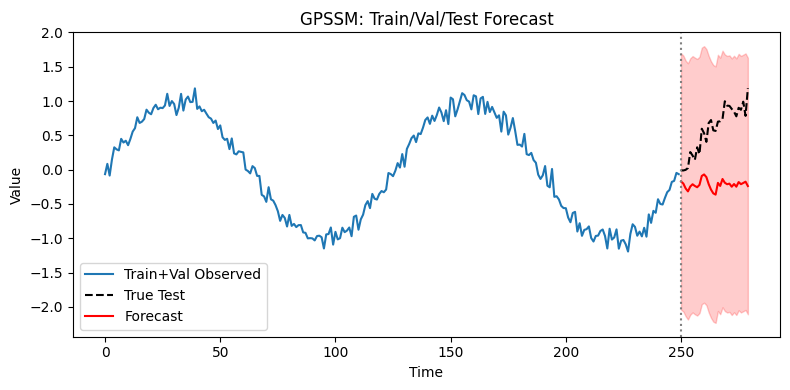

In [15]:
# Plot train+val, true test, and forecasts
plt.figure(figsize=(8, 4))
# Plot everything up to 250
plt.plot(
    np.arange(5*window),
    series[:5*window],
    label="Train+Val Observed"
)
# True test
t_test = np.arange(5*window, 5*window+horizon)
plt.plot(t_test, test_true, '--k', label="True Test")
# Forecast mean + 95% CI
plt.plot(t_test, y_pred, 'r', label="Forecast")
plt.fill_between(
    t_test,
    y_pred - 1.96*y_std,
    y_pred + 1.96*y_std,
    color='r',
    alpha=0.2
)
plt.axvline(5*window, color='grey', linestyle=':')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("GPSSM: Train/Val/Test Forecast")
plt.tight_layout()
plt.show()

In [16]:
# Compute Test RMSE
rmse = np.sqrt(np.mean((y_pred - test_true)**2))
print(f"Test RMSE over horizon of {horizon} timesteps: {rmse:.4f}")

Test RMSE over horizon of 30 timesteps: 0.8684


# Actuator Demo

In [17]:
# Download and display the actuator dataset
df = pd.read_csv(
    "https://ftp.esat.kuleuven.be/pub/SISTA/data/mechanical/robot_arm.dat.gz",
    compression="gzip",
    sep=r"\s+",
    header=None,
    names=["u", "y"],
)

print(df.shape)
display(df.head())

(1024, 2)


,u,y
0,0.221832,-0.177036
1,0.039028,-0.114708
2,-0.050296,-0.017258
3,0.008539,0.073361
4,0.072431,0.128063


In [18]:
# Normalize the data
u_raw = df["u"].values  # Measured reaction torque of the arm's mounting structure
y_raw = df["y"].values  # Resulting acceleration of the flexible arm

u_mu = u_raw.mean()
u_sd = u_raw.std()
y_mu = y_raw.mean()
y_sd = y_raw.std()

u = (u_raw - u_mu) / u_sd
y = (y_raw - y_mu) / y_sd

In [19]:
class ActuatorDataset(Dataset):
    def __init__(self, u, y, window):
        self.u = torch.from_numpy(u).float().unsqueeze(-1)
        self.y = torch.from_numpy(y).float().unsqueeze(-1)
        self.window = window

    def __len__(self):
        return len(self.y) - self.window

    def __getitem__(self, idx):
        y_seq = self.y[idx:idx + self.window]
        u_seq = self.u[idx:idx + self.window]
        return y_seq, u_seq

In [20]:
# Create sliding-window dataset
window = 50
horizon = 30

dataset = ActuatorDataset(u, y, window)

In [21]:
# Train/validation/test split
n_total = len(dataset)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)

train_ds = Subset(dataset, range(0, n_train))
val_ds = Subset(dataset, range(n_train, n_train + n_val))
test_ds = Subset(dataset, range(n_train + n_val, n_total))

In [22]:
# DataLoaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

In [23]:
# Instantiate GPSSM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

obs_dim = 1
act_dim = 1
state_dim = 4
hid_dim = 20
M = 30

Z = torch.randn(M, state_dim + act_dim).to(device)
model = GPSSM(
    obs_dim=obs_dim,
    act_dim=act_dim,
    state_dim=state_dim,
    hid_dim=hid_dim,
    Z=Z,
    num_mc_samples=5
).to(device)

Epoch 001 | train NELBO = 1494.0377 | val NELBO = 1545.8599
Epoch 002 | train NELBO = 1348.5197 | val NELBO = 1285.5295
Epoch 003 | train NELBO = 1171.3775 | val NELBO = 1182.2881
Epoch 004 | train NELBO = 1115.4428 | val NELBO = 1130.2500
Epoch 005 | train NELBO = 1082.3001 | val NELBO = 1140.5443
Epoch 006 | train NELBO = 1077.2474 | val NELBO = 1106.1804
Epoch 007 | train NELBO = 1061.4378 | val NELBO = 1133.1521
Epoch 008 | train NELBO = 1047.4564 | val NELBO = 1061.3858
Epoch 009 | train NELBO = 1034.2092 | val NELBO = 1041.3241
Epoch 010 | train NELBO = 1026.0895 | val NELBO = 1071.1911
Epoch 011 | train NELBO = 1020.6274 | val NELBO = 1041.8430
Epoch 012 | train NELBO = 1006.9341 | val NELBO = 1019.8631
Epoch 013 | train NELBO = 981.8692 | val NELBO = 1011.0663
Epoch 014 | train NELBO = 970.6041 | val NELBO = 981.8646
Epoch 015 | train NELBO = 961.3025 | val NELBO = 976.4943
Epoch 016 | train NELBO = 952.5019 | val NELBO = 968.3852
Epoch 017 | train NELBO = 941.1911 | val NELBO 

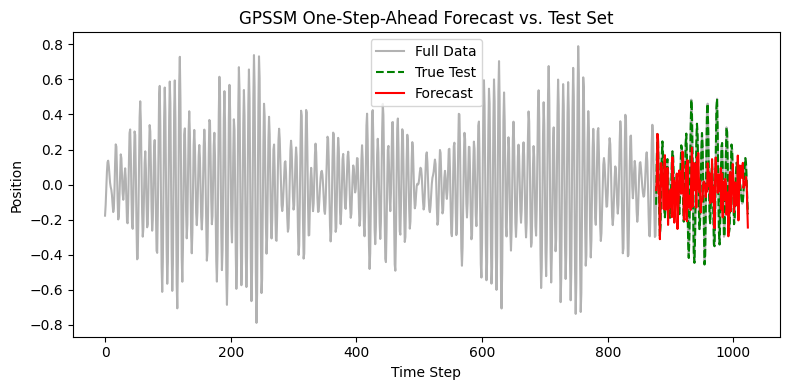

In [24]:
# Train with validation checkpointing
model = train(
    model,
    train_loader,
    val_loader,
    lr=1e-3,
    epochs=300
)

# One-step-ahead rolling forecast over the test set
model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    start_idx = n_train + n_val
    for win_idx in range(start_idx, n_total):
        # Context window
        y_ctx, u_ctx = dataset[win_idx]
        y_obs = y_ctx.unsqueeze(0).to(device)
        u_obs = u_ctx.unsqueeze(0).to(device)

        # True next control and observation
        t_next = win_idx + window
        u_next_val = (u_raw[t_next] - u_mu) / u_sd
        u_next = torch.tensor(
            u_next_val,
            dtype=torch.float32,
            device=device
        ).view(1, 1, 1)

        # Forecast one step ahead
        y_pred_norm, _ = model.forecast(
            y_obs,
            a_obs=u_obs,
            horizon=1,
            actions_future=u_next,
            use_map=False,
            num_samples=1,
        )
        y_pred_val = y_pred_norm.cpu().item()
        y_pred_list.append(y_pred_val)

        # Record true next observation
        y_true_list.append(y_raw[t_next])

# De-normalize and compute metrics
print("\n\n")
y_pred_arr = np.array(y_pred_list) * y_sd + y_mu
y_true_arr = np.array(y_true_list)

error = y_pred_arr - y_true_arr
rmse = np.sqrt(np.mean(error ** 2))
mae = np.mean(np.abs(error))
denom = np.where(y_true_arr == 0, 1e-6, y_true_arr)
mape = np.mean(np.abs(error / denom)) * 100

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")

# Plot one-step-ahead forecasts vs. true test series
print("\n\n")
t_full = np.arange(len(y_raw))
t_test = np.arange(
    start_idx + window,
    start_idx + window + len(y_pred_arr),
)

plt.figure(figsize=(8, 4))
plt.plot(t_full, y_raw, "-", color="k", alpha=0.3, label="Full Data")
plt.plot(t_test, y_true_arr, "--", color="g", label="True Test")
plt.plot(t_test, y_pred_arr, "-", color="r", label="Forecast")

plt.xlabel("Time Step")
plt.ylabel("Position")
plt.legend()
plt.title("GPSSM One-Step-Ahead Forecast vs. Test Set")
plt.tight_layout()
plt.show()